In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

def figsize(width=16, height=8):
    pylab.rcParams['figure.figsize'] = (width, height)

In [78]:
import numpy as np
from collections import defaultdict


class Glicko:

    def __init__(self, q=None, c=None, plt=None):
        self.q = q
        self.c = c
        self.plt = plt

    def _weekly_evolve_rd(self, rd, n_weeks):
        n_weeks = int(n_weeks)
        if n_weeks <= 0:
            return min(350, rd)
        else:
            return self._weekly_evolve_rd(
                np.sqrt(np.power(rd, 2) + np.power(self.c, 2)), n_weeks - 1
            )

    def _aux_g(self, rd):
        return np.power(1 + 3 * np.power(self.q * rd / np.pi, 2), -1 / 2)

    def _aux_esp(self, r, ro, rdo):
        return 1 / (1 + np.power(10, - self._aux_g(rdo) * (r - ro) / 400))

    def _aux_dsquare(self, r, ro, rdo):
        esp_tmp = self._aux_esp(r, ro, rdo)
        return 1 / (np.power(self.q * self._aux_g(rdo), 2) * esp_tmp * (1 - esp_tmp))

    def _aux_glicko(self, r, rd, ro, rdo, s):  # s is the outcome
        denom = 1 / (rd ** 2) + 1 / self._aux_dsquare(r, ro, rdo)
        new_r = r + self.q * self._aux_g(rdo) * (s - self._aux_esp(r, ro, rdo)) / denom
        new_rd = np.power(denom, - 1 / 2)
        return new_r, new_rd

    def glicko(self, games, init_rating=None, init_rds=None, exp_kernel=0.3):
        """
        Adds columns with glicko ratings and rating deviations in the given dataframe. Handles only
        one season.
        :param games: The dataframe containing the game information (retrieved via
        gamesloader.Top14Loader.get_consolidated_games).
        :param init_rating: Initial values for the ratings.
        :param init_rds: Initial values for the rating deviations.
        :return: The updated dataframe, a dictionary of the team ratings
        and a dictionary of the team rating deviations.
        """
        if self.q is None or self.c is None:
            raise ValueError("q or c attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_ratings = {}
        team_rds = {}
        team_previous_ratings = {}
        if init_rating is None:
            for team in teams:
                team_ratings[team] = 1500
                team_rds[team] = 350
        else:
            # Use the previons ratings (np array of dim n_teams, 2) to calculate the new ratings for the
            # new teams (use the same rating as previously for teams staying in the game and
            # using the mean
            # of the rating of the exiting team for the entering teams) with an expanded rating deviation
            # (even more expanded for the new teams)
            for team in teams:
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                    team_rds[team] = self._weekly_evolve_rd(init_rds[team], 12)
                else:
                    team_ratings[team] = 1500
                    team_rds[team] = 350
        # Initialize teams_last_game
        teams_last_game = {}
        for team in teams:
            team_filter = (games["home_team"] == team) | (games["away_team"] == team)
            teams_last_game[team] = list(games[team_filter]["datetime"])[0]
        # Initialize team_shape
        team_shape= {}
        for team in teams:
            team_shape[team] = 0
        
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            games.loc[games_index, "home_shape"] = 0
            games.loc[games_index, "away_shape"] = 0
            # Compute s (outcome)
            s = 0
            if row["home_score"] > row["away_score"]:
                s = 1
            elif row["home_score"] == row["away_score"]:
                s = 1 / 2
            # retrieve current values
            r = team_ratings[home_team]
            rd = team_rds[home_team]
            ro = team_ratings[away_team]
            rdo = team_rds[away_team]
            if home_team in team_previous_ratings:
                prev_r = team_previous_ratings[home_team]
                shape = team_shape[home_team]
                games.loc[games_index, "home_shape"] = exp_kernel*(r - prev_r)+(1-exp_kernel)*shape
                team_shape[home_team] = shape
            if away_team in team_previous_ratings:
                prev_ro = team_previous_ratings[away_team]
                shape_o = team_shape[away_team]
                games.loc[games_index, "away_shape"] = exp_kernel*(ro - prev_ro)+(1-exp_kernel)*shape_o
                team_shape[away_team] = shape_o
            # Update rating deviation
            home_game_dt = (row["datetime"] - teams_last_game[home_team]).days / 7
            away_game_dt = (row["datetime"] - teams_last_game[away_team]).days / 7
            prev_rd = self._weekly_evolve_rd(rd, home_game_dt)
            prev_rdo = self._weekly_evolve_rd(rdo, away_game_dt)
            # Compute
            new_r_home, new_rd_home = self._aux_glicko(r, prev_rd, ro, prev_rdo, s)
            new_r_away, new_rd_away = self._aux_glicko(ro, prev_rdo, r, prev_rd, 1 - s)
            # Update
            # ----- Store result
            games.loc[games_index, "home_r"] = new_r_home
            games.loc[games_index, "home_rd"] = new_rd_home
            games.loc[games_index, "away_r"] = new_r_away
            games.loc[games_index, "away_rd"] = new_rd_away
            games.loc[games_index, "prev_home_r"] = r
            games.loc[games_index, "prev_away_r"] = ro
            games.loc[games_index, "prev_home_rd"] = rd
            games.loc[games_index, "prev_away_rd"] = rdo
            # ----- Update function helper variables
            team_ratings[home_team] = new_r_home
            team_ratings[away_team] = new_r_away
            team_rds[home_team] = new_rd_home
            team_rds[away_team] = new_rd_away
            teams_last_game[home_team] = row["datetime"]
            teams_last_game[away_team] = row["datetime"]
            team_previous_ratings[home_team] = r
            team_previous_ratings[away_team] = ro
        return games, team_ratings, team_rds


    def plot_glicko(self, df, show=False, legend=True, teams=None):
        """
        Helper function to plot the glicko rating evolution for the different teams.
        :param df: The dataframe containing the games information with the ratings.
        :param show: Boolean, indicates whether plt.show() should be called. Defaults to False.
        :param legend: Boolean, indicates whether the legend should be shown. Defaults to True.
        :param teams: A list of the teams for which the glicko rating should be plotted.
        :return: None
        """
        if teams is None:
            teams = set(df["home_team"]) | set(df["away_team"])
        else:
            teams_set = set(df["home_team"]) | set(df["away_team"])
            for team in teams:
                if team not in teams_set:
                    raise ValueError(f"The team {team} is not in the set of teams.")
        if self.plt is None:
            raise ValueError("The plt attribute of the Glicko instance has not been initialized.")
        teams_ratings = defaultdict(list)
        teams_games_dt = defaultdict(list)
        for _, row in df.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            teams_ratings[home_team].append(row["home_r"])
            teams_ratings[away_team].append(row["away_r"])
            teams_games_dt[home_team].append(row["datetime"])
            teams_games_dt[away_team].append(row["datetime"])
        for team in teams:
            self.plt.plot(teams_games_dt[team], teams_ratings[team], "--o", label=team)
        if legend:
            self.plt.legend()
        if show:
            self.plt.show()

In [79]:
class Pi_rating:
    
    def __init__(self, c=None, l=None, gamma=None):
        self.c = c
        self.l = l
        self.gamma = gamma
    
    def _aux_phi(self,e):
        return self.c*np.log(e+1)
    
    def _aux_predict_difference(self,r):
        r2=np.abs(r)
        g_pred = np.exp(r2/self.c) - 1
        if r>0:
            return g_pred
        else:
            return (-g_pred)
    
    def _aux_error(self,g,r):
        g_pred = self._aux_predict_difference(r)
        return np.abs(g_pred-g)
    
    def pi_rating(self, games, init_rating=None):
        
        if self.c is None or self.l is None or self.gamma is None:
            raise ValueError("c, l or gamma attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_home_ratings = {}
        team_away_ratings = {}
        if init_rating is None:
            for team in teams:
                team_home_ratings[team] = 0
                team_away_ratings[team] = 0
        else:
            for team in teams:
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                else:
                    team_ratings[team] = 0
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            # retrieve current values
            rhh = team_home_ratings[home_team]
            rha = team_away_ratings[home_team]
            rah = team_home_ratings[away_team]
            raa = team_away_ratings[away_team]
            # Calculate new values
            g = row["home_score"] - row["away_score"]
            g_pred_home_team = self._aux_predict_difference(rhh)
            g_pred_away_team = self._aux_predict_difference(raa)
            g_pred = g_pred_home_team - g_pred_away_team
            e = np.abs(g - g_pred)
            p = self._aux_phi(e)
            # Compute
            if g_pred < g:
                new_rhh = rhh + p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa - p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            else :
                new_rhh = rhh - p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa + p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            # Update
            # ----- Store result
            games.loc[games_index, "home_r_at_home"] = new_rhh
            games.loc[games_index, "home_r_away"] = new_rha
            games.loc[games_index, "away_r_at_home"] = new_rah
            games.loc[games_index, "away_r_away"] = new_raa
            games.loc[games_index, "prev_home_r_at_home"] = rhh
            games.loc[games_index, "prev_home_r_away"] = rha
            games.loc[games_index, "prev_away_r_at_home"] = rah
            games.loc[games_index, "prev_away_r_away"] = raa
            # ----- Update function helper variables
            team_home_ratings[home_team] = new_rhh
            team_away_ratings[home_team] = new_rha
            team_home_ratings[away_team] = new_rah
            team_away_ratings[away_team] = new_raa
        return games, team_home_ratings, team_away_ratings

    # New parameter: percentage of away wins among all the wins
    
    def awayshape(self, games):
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        prev_number_away_wins = {}
        prev_number_wins = {}
        prev_score = {}
        for team in teams:
            prev_number_away_wins[team] = 1
            prev_number_wins[team] = 1
            prev_score[team] = 0
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            h1 = prev_number_away_wins[home_team]
            h2 = prev_number_wins[home_team]
            a1 = prev_number_away_wins[away_team]
            a2 = prev_number_wins[away_team]
            rh = h1/h2
            ra = a1/a2
            home_s = prev_score[home_team]
            away_s = prev_score[away_team]
            games.loc[games_index, "home_awayshape"] = rh
            games.loc[games_index, "away_awayshape"] = ra
            games.loc[games_index, "home_number_of_wins"] = h2
            games.loc[games_index, "away_number_of_wins"] = a2
            games.loc[games_index, "home_number_of_wins_away"] = h1
            games.loc[games_index, "away_number_of_wins_away"] = a1
            games.loc[games_index, "home_prev_score"] = home_s
            games.loc[games_index, "away_prev_score"] = away_s
            if row["home_score"] < row["away_score"]:
                prev_number_away_wins[away_team]+= 1
                prev_number_wins[away_team]+= 1
            elif row["home_score"] > row ["away_score"]:
                prev_number_wins[home_team]+= 1
            prev_score[home_team] = row["home_score"]
            prev_score[away_team] = row["away_score"]
        return games

In [80]:
Gl=Glicko()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
q=np.log(10)/2000
c=60
Gl.__init__(q,c)
df2, _, _ =Gl.glicko(df,exp_kernel=0.5)

Pr=Pi_rating()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
c = 3
l = 0.035
gamma = 0.7
Pr.__init__(c,l,gamma)
df3,_,_=Pr.pi_rating(df2)
df4 = Pr.awayshape(df3)
df4


season_order               home_team               away_team  \
185              0           USA Perpignan        Aviron Bayonnais   
184              1               Montauban        Stade Toulousain   
183              2           RC Toulonnais    Stade Francais Paris   
182              3     CS Bourgoin Jallieu                Clermont   
181              4                CA Brive  Montpellier Herault RC   
180              5      Biarritz Olympique       Castres Olympique   
179              6                    Albi               Racing 92   
178              7        Aviron Bayonnais    Stade Francais Paris   
177              8        Stade Toulousain                CA Brive   
176              9  Montpellier Herault RC           USA Perpignan   
175             10                Clermont               Montauban   
174             11      Biarritz Olympique                    Albi   
173             12           RC Toulonnais               Racing 92   
172             13       Castres Olympique     CS Bourgoin Jallieu   
171             14                CA Brive                Clermont   
170             15    Stade Francais Paris  Montpellier Herault RC   
169             16               Racing 92        Aviron Bayonnais   
168             17           USA Perpignan        Stade Toulousain   
167             18     CS Bourgoin Jallieu      Biarritz Olympique   
166             19                    Albi           RC Toulonnais   
165             20           USA Perpignan                CA Brive   
164             21        Stade Toulousain        Aviron Bayonnais   
163             22    Stade Francais Paris               Montauban   
162             23           RC Toulonnais                Clermont   
161             24  Montpellier Herault RC      Biarritz Olympique   
160             25     CS Bourgoin Jallieu               Racing 92   
159             26               Montauban           RC Toulonnais   
158             27               Racing 92           USA Perpignan   
157             28       Castres Olympique  Montpellier Herault RC   
156             29                CA Brive                    Albi   
...            ...                     ...                     ...   
1524           158                    Agen  Union Sportive Oyonnax   
1523           159  Montpellier Herault RC             La Rochelle   
1522           160               Racing 92           RC Toulonnais   
1521           161           RC Toulonnais  Montpellier Herault RC   
1520           162  Union Sportive Oyonnax                CA Brive   
1519           163         Section Paloise                    Agen   
1518           164                Clermont         Bordeaux Begles   
1517           165                    Lyon    Stade Francais Paris   
1516           166             La Rochelle       Castres Olympique   
1515           167        Stade Toulousain               Racing 92   
1514           168           RC Toulonnais       Castres Olympique   
1513           169  Union Sportive Oyonnax                    Lyon   
1512           170    Stade Francais Paris                CA Brive   
1511           171  Montpellier Herault RC         Section Paloise   
1510           172                    Agen                Clermont   
1509           173         Bordeaux Begles               Racing 92   
1508           174        Stade Toulousain             La Rochelle   
1507           175         Section Paloise           RC Toulonnais   
1506           176               Racing 92                    Agen   
1505           177                    Lyon  Montpellier Herault RC   
1504           178             La Rochelle    Stade Francais Paris   
1503           179                Clermont        Stade Toulousain   
1502           180       Castres Olympique  Union Sportive Oyonnax   
1501           181                CA Brive         Bordeaux Begles   
1500           182             Grenoble FC  Union Sportive Oyonnax   
1499           1

In [81]:
list(df4)

['season_order',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'home_win_main_odd',
 'home_loss_main_odd',
 'draw_main_odd',
 'n_bookies',
 'season',
 'lnr_id',
 'datetime',
 'home_shape',
 'away_shape',
 'home_r',
 'home_rd',
 'away_r',
 'away_rd',
 'prev_home_r',
 'prev_away_r',
 'prev_home_rd',
 'prev_away_rd',
 'home_r_at_home',
 'home_r_away',
 'away_r_at_home',
 'away_r_away',
 'prev_home_r_at_home',
 'prev_home_r_away',
 'prev_away_r_at_home',
 'prev_away_r_away',
 'home_awayshape',
 'away_awayshape',
 'home_number_of_wins',
 'away_number_of_wins',
 'home_number_of_wins_away',
 'away_number_of_wins_away',
 'home_prev_score',
 'away_prev_score']

/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7432950191570882


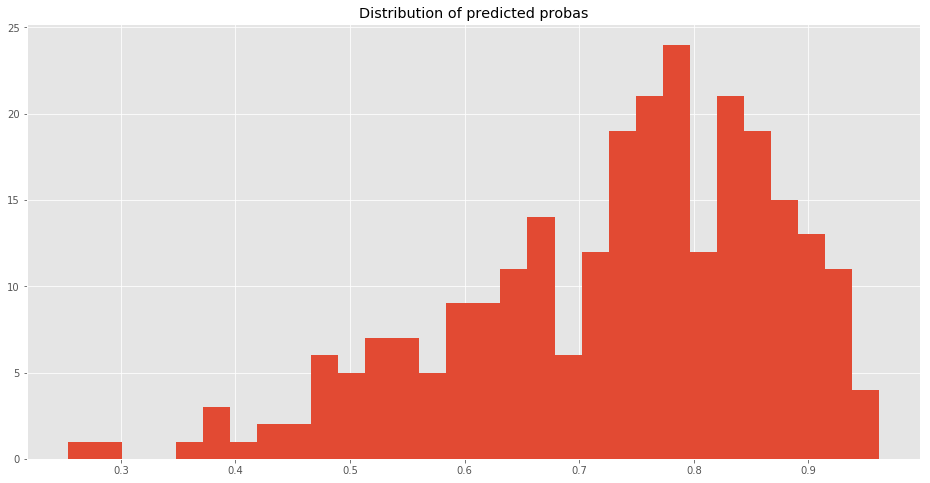

In [100]:
games_filtered = df4[df4["season_order"] >= 42]

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]
lr.fit(train_df[[
 "prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[[
 "prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"
]], test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[[
"prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

In [83]:
#Selection of the parameters in order to maximise the accuracy

all_parameters = ["home_shape",
 "away_shape",
 "prev_home_r",
 "prev_away_r",
 "prev_home_rd",
 "prev_away_rd",
 "prev_home_r_at_home",
 "prev_home_r_away",
 "prev_away_r_at_home",
 "prev_away_r_away",
 "home_awayshape",
 "away_awayshape",
 "home_number_of_wins",
 "away_number_of_wins",
 "home_number_of_wins_away",
 "away_number_of_wins_away",
 "home_prev_score",
 "away_prev_score"]

def enumere_liste(l,k):
    if k==1:
        v = []
        for i in l:
            v = v +[[i]]
        return v
    else:
        b = enumere_liste(l,k-1)
        for u in b:
            for i in l:
                v = u + [i]
                b = b + [v]
        return b

k = len(all_parameters)
m = 0
best_parameters = []

for l in enumere_liste(all_parameters,k):
    a0 = l[0]
    l.remove(a0)
    train_bis = train_df[[a0]]
    test_bis = test_df[[a0]]
    for b in l:
        train_bis = pd.merge(train_bis,train_df[[a0,b]]) #adding new column to dataframe
        test_bis = pd.merge(test_bis,test_df[[a0,b]])
    lr.fit(train_bis, train_df["home_score"] > train_df["away_score"])
    n = lr.score(test_bis, test_df["home_score"] > test_df["away_score"])
    if n > m:
        m = n
        l.append(a0)
        best_parameters = l
best_parameters

    

SyntaxError: invalid syntax (<ipython-input-83-9f68dbf64666>, line 26)

In [ ]:
df5 = train_df[[a]]
pd.merge(df5,train_df[[a,"home_score"]])